In [79]:
import pandas as pd
from pathlib import Path
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import word_tokenize
import re
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn import svm
import numpy as np
from nltk import ngrams
import seaborn as sns

#### Dataset construction

In [80]:
# Parent directories, 'orginal' stores the original chapters translated by machine or by different translators; 
#                     'cleaned' stores the cleaned files by data pre-processing
ORIGINAL_DIR = Path('original')
CLEANED_DIR = Path('cleaned')

# Chuildren directories for each parent directory
PO_GOO_DIR = Path('po-goo') # stores chapters translated by Google Translate from the original version (Polish) of the book Solaris to English
PO_DL_DIR = Path('po-dl') # stores chapters translated by DeepL API from the original version (Polish) of the book Solaris to English
FR_GOO_DIR = Path('fr-goo') # stores chapters translated by Google Translate from the translated french version of the book Solaris to English
FR_DL_DIR = Path('fr-dl') # stores chapters translated by DeepL API from the translated french version of the book Solaris to English
EN1_DIR = Path('fr-h') # stores chapters of first translated version to English of the book Solaris
EN2_DIR = Path('po-h') # stores chapters of second translated version to English of the book Solaris

# List to access children directories
DIRS = [PO_GOO_DIR, PO_DL_DIR, FR_GOO_DIR, FR_DL_DIR, EN1_DIR, EN2_DIR]

# List for all the translations
BOOKS = ['po-goo', 'po-dl', 'fr-goo', 'fr-dl', 'fr-h', 'po-h']

#### TF-IDF construction 

In [81]:
# a set of all the words in all documents
all_trigrams = set()
# txt -> a list, where each element is a string of the single chapter
txt = []

vectorizer = CountVectorizer(ngram_range =(3, 3))

for i in DIRS:
    for j in (CLEANED_DIR / i).iterdir():
        with open(j, "r") as f:
            chp = f.read()
            txt.append(chp)

# vectorise the whole corpus, by chapter
trigrams = vectorizer.fit_transform(txt) 
all_trigrams = all_trigrams.union(set(vectorizer.get_feature_names_out()))
        
all_trigrams_len = len(all_trigrams) 
trigrams.toarray().sum(axis=1)

array([3281, 2977, 4462, 2300, 8255, 3443, 5287, 4381, 2271, 4337, 6829,
       4651, 3419, 5565, 3550, 3126, 4754, 2465, 8854, 3665, 5641, 4728,
       2429, 4748, 7415, 4934, 3566, 6088, 4582, 4231, 5511, 3336, 6985,
       2327, 8576, 3513, 2228, 4365, 4628, 3423, 5839, 3084, 4634, 4310,
       5496, 3329, 7070, 2338, 8574, 3522, 2231, 4428, 4608, 3424, 5876,
       3074, 5767, 2272, 2265, 4386, 4536, 4414, 7265, 3162, 3301, 3286,
       3336, 8144, 5655, 4559, 7559, 4883, 4970, 2581, 5926, 3230, 3826,
       9257, 6426, 2450, 5144, 4918, 3854, 4970])

In [82]:
'''Get the TF-IDF for each chapter'''
vectorizer = TfidfVectorizer(ngram_range = (3, 3), norm='l1')
tfidf = vectorizer.fit_transform(txt)
scores = tfidf.toarray()
tfi_df = pd.DataFrame(scores, columns=vectorizer.get_feature_names_out(), index=[f"{b}-{i}" for b in BOOKS for i in range(1,15)])

# Check the normalisation
# tfi_df.sum(axis=1)

In [83]:
'''Get the TF-IDF for each document '''
all_df = tfi_df.T
all_df['po-goo'] = all_df.loc[:,all_df.columns.str.startswith('po-goo-')].sum(axis=1)/14
all_df['po-dl'] = all_df.loc[:,all_df.columns.str.startswith('po-dl-')].sum(axis=1)/14
all_df['fr-goo'] = all_df.loc[:,all_df.columns.str.startswith('fr-goo-')].sum(axis=1)/14
all_df['fr-dl'] = all_df.loc[:,all_df.columns.str.startswith('fr-dl-')].sum(axis=1)/14
all_df['fr-h'] = all_df.loc[:,all_df.columns.str.startswith('fr-h-')].sum(axis=1)/14
all_df['po-h'] = all_df.loc[:,all_df.columns.str.startswith('po-h-')].sum(axis=1)/14

doc_df = all_df.iloc[:, -6:]
# Normalisation check
# doc_df.sum(axis=0)

# Transpose fit pca input type
chp_df = tfi_df
doc_df = doc_df.T

#### Graph plotting by PCA features 

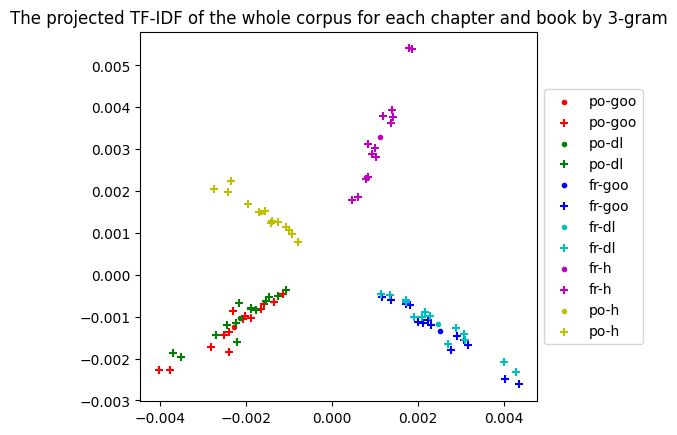

In [84]:
'''Plotting the pca features for each chapter and each book by 3-gram'''
# Applies principal component analysis
pca = PCA(n_components=2)
pca_doc = pca.fit_transform(doc_df)
pca_chp = pca.transform(chp_df)

# COLOUR_MAP = "tab10"
# CMAP = plt.get_cmap(COLOUR_MAP)
# rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

# colours = [CMAP(i) for i in rescale(np.arange(6))]
colours = ['r','g','b','c','m','y']
# plt.style.use('ggplot')
ax = plt.subplot(111)
for i in range(6):
    ax.scatter(pca_doc[i,0], pca_doc[i,1], color=colours[i], marker='.', label=BOOKS[i])
    ax.scatter(pca_chp[14*i:14*(i+1),0], pca_chp[14*i:14*(i+1),1], color=colours[i], marker='+', label=BOOKS[i])

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.set_title('The projected TF-IDF of the whole corpus for each chapter and book by 3-gram')
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(Path('trigram-graph') / "all.png")
plt.show()

In [85]:
'''Pick out the top 200 most frequent bigrams (exclude any proper nouns) '''
top200 = tfi_df.sum(axis=0).sort_values(ascending=[False]).head(200)
top200 = list(top200.index)
# doc_df.sum(axis=0)
top200

['what do you',
 'of the ocean',
 'looked at me',
 'in front of',
 'there was no',
 'do you want',
 'what are you',
 'you want to',
 'on the floor',
 'looking at me',
 'he looked at',
 'the same time',
 'at the same',
 'to me that',
 'of the station',
 'do not know',
 'do you know',
 'you know what',
 'as if he',
 'you dont know',
 'surface of the',
 'dont want to',
 'do you mean',
 'that it was',
 'do you think',
 'one of the',
 'that the ocean',
 'the living ocean',
 'out of the',
 'the ocean was',
 'the end of',
 'at me with',
 'where is he',
 'seemed to me',
 'was no longer',
 'in the middle',
 'on the table',
 'of the planet',
 'the middle of',
 'how do you',
 'it seemed to',
 'the surface of',
 'closed my eyes',
 'into the ocean',
 'edge of the',
 'the edge of',
 'must have been',
 'was looking at',
 'why are you',
 'the sound of',
 'the radio station',
 'front of me',
 'on the station',
 'for long time',
 'end of the',
 'be able to',
 'middle of the',
 'the first time',
 'the re

#### Applying SVC classifier

In [86]:
'''Plotting graph based on PCA and SVC'''
# List of svc kernel
svc_kernel = ['poly', 'linear','rbf', 'sigmoid']
def make_graph(doc1, doc2, words, title, fig_name):
    # Construct data
    df_doc = all_df.loc[words, [doc1, doc2]].T
    cols = [f"{doc1}-{i}" for i in range(1,15)] + [f"{doc2}-{i}" for i in range(1,15)]
    df_chp = all_df.loc[words,cols].T

    # Normalised data
    df_doc = df_doc.div(df_doc.sum(axis=1),axis=0)
    df_chp = df_chp.div(df_chp.sum(axis=1),axis=0)

    # Applies principal component analysis
    pca = PCA(n_components=2)
    doc = pca.fit_transform(df_doc)
    chp = pca.transform(df_chp)

    # Skeloton code for plotting taken from:
    # https://stackoverflow.com/a/51301399
    def make_meshgrid(x, y, h=.02):
        x_min, x_max = x.min() - 1, x.max() + 1
        y_min, y_max = y.min() - 1, y.max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        return xx, yy

    def plot_contours(ax, clf, xx, yy, **params):
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        out = ax.contourf(xx, yy, Z, **params)
        return out

    y = [0]*14 + [1]*14
    LABELS = [doc1, doc2]

    best_clf = None
    best_acurracy = 0
    for k in svc_kernel:
      np.random.seed(3)
      model = svm.SVC(kernel=k)
      clf = model.fit(chp, y)
      acurracy = (model.predict(chp) == np.array(y)).sum() / 28
      if acurracy > best_acurracy:
        best_clf = clf
        best_acurracy = acurracy


    fig, ax = plt.subplots()
    # Set-up grid for plotting.
    X0, X1 = chp[:, 0], chp[:, 1]
    xx, yy = make_meshgrid(X0, X1)

    plot_contours(ax, best_clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    # ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.scatter(X0[:14], X1[:14], color=plt.cm.coolwarm(0.0), s=20, edgecolors='k', label=LABELS[0])
    ax.scatter(X0[14:], X1[14:], color=plt.cm.coolwarm(1.0), s=20, edgecolors='k', label=LABELS[1])

    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

    ax.set_xlim([-0.05,0.05])
    ax.set_ylim([-0.05,0.05])
    ax.legend()
    plt.savefig(Path('trigram-graph') / fig_name)
    acurracy = (model.predict(chp) == np.array(y)).sum() / 28
    print(acurracy)
    
    plt.show()


/home/mingyue/.local/lib/python3.10/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/home/mingyue/.local/lib/python3.10/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/home/mingyue/.local/lib/python3.10/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/home/mingyue/.local/lib/python3.10/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/home/mingyue/.local/lib/python3.10/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/home

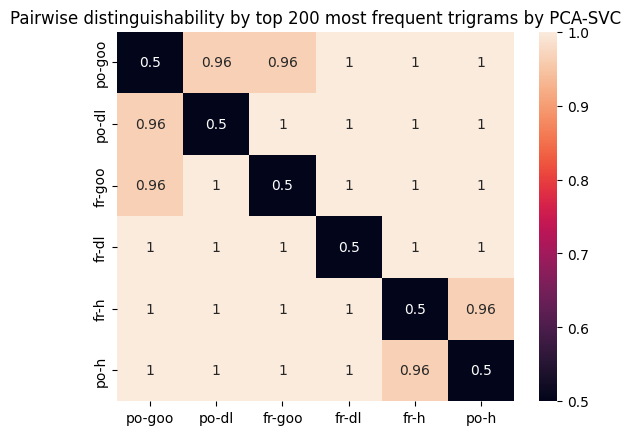

In [87]:
'''Heatmap for accuracy for SVC for document pair by top 200 most frequent words'''
heatmap_data = pd.DataFrame(0, index=BOOKS, columns=BOOKS)

# List of svc kernel
svc_kernel = ['poly', 'linear','rbf', 'sigmoid']

# Get accuracy for all the document pairs
for idx in range(len(BOOKS)):
  for jdx in range(idx,len(BOOKS)):
    i = BOOKS[idx]
    j = BOOKS[jdx]
    # Construct data
    df_doc = all_df.loc[top200, [i, j]].T
    cols = [f"{i}-{each}" for each in range(1,15)] + [f"{j}-{each}" for each in range(1,15)]
    df_chp = all_df.loc[top200,cols].T

    # Normalised data
    df_doc = df_doc.div(df_doc.sum(axis=1),axis=0)
    df_chp = df_chp.div(df_chp.sum(axis=1),axis=0)

    # Applies principal component analysis
    pca = PCA(n_components=2)
    doc = pca.fit_transform(df_doc)
    chp = pca.transform(df_chp)
    y = [0]*14 + [1]*14
    
    best_acurracy = 0
    for k in svc_kernel:
      model = svm.SVC(kernel=k)
      clf = model.fit(chp, y)
      acurracy = (model.predict(chp) == np.array(y)).sum() / 28
      if acurracy > best_acurracy:
        best_acurracy = acurracy
    
    heatmap_data.loc[i,j] = best_acurracy
    heatmap_data.loc[j,i] = best_acurracy
plt.title("Pairwise distinguishability by top 200 most frequent trigrams by PCA-SVC")
sns.heatmap(heatmap_data, annot=True)
plt.savefig(Path('trigram-graph') / 'heatmap-top200')

0.9642857142857143


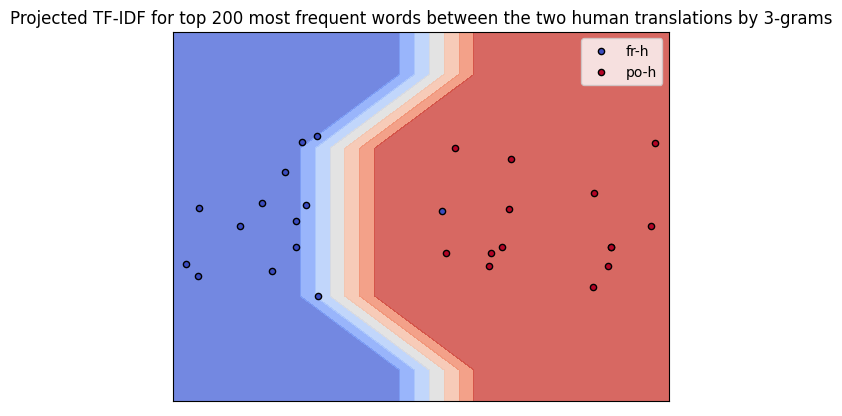

In [88]:
make_graph(
    "fr-h", "po-h", top200,
    'Projected TF-IDF for top 200 most frequent words between the two human translations by 3-grams',
    'fp-h-200.png'
)

0.9642857142857143


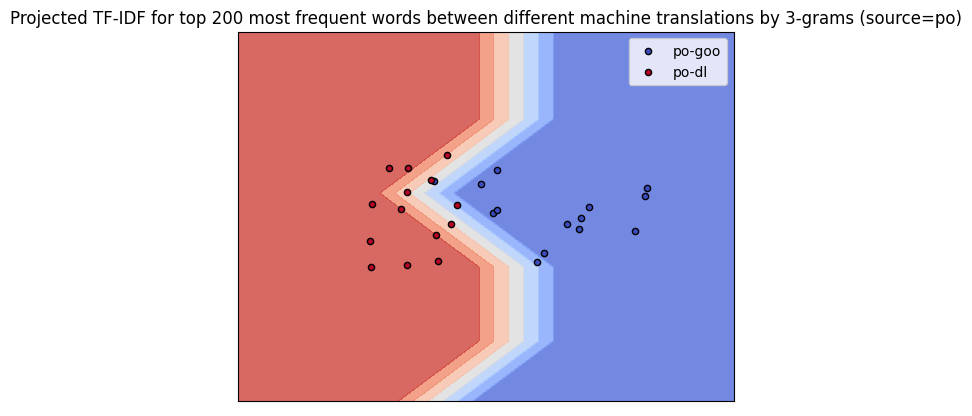

In [89]:
make_graph(
    "po-goo", "po-dl", top200,
    'Projected TF-IDF for top 200 most frequent words between different machine translations by 3-grams (source=po)',
    'pp-gl-200.png'
)

0.9642857142857143


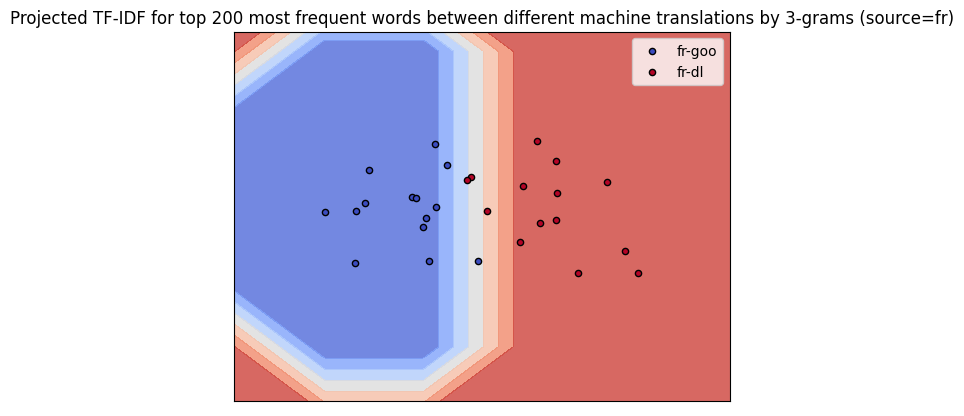

In [90]:
make_graph(
    "fr-goo", "fr-dl", top200,
    'Projected TF-IDF for top 200 most frequent words between different machine translations by 3-grams (source=fr)',
    'ff-gl-200.png'
)